# Clone git

In [1]:
!git clone https://github.com/ttharden/Keyframe-Extraction-for-video-summarization

Cloning into 'Keyframe-Extraction-for-video-summarization'...
remote: Enumerating objects: 197, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 197 (delta 30), reused 20 (delta 19), pack-reused 159 (from 1)
Receiving objects: 100% (197/197), 2.55 MiB | 8.78 MiB/s, done.
Resolving deltas: 100% (47/47), done.


# Import Thư viện

In [2]:
import sys
import os
import pickle
import numpy as np

# Thêm đường dẫn gốc

In [3]:
sys.path.append("/kaggle/working/Keyframe-Extraction-for-video-summarization/src/extraction")

# Đọc embeding

In [7]:
embedding_path = '/kaggle/input/video-embedding-sample/video_features.pkl'
with open(embedding_path, "rb") as f:
    embeddings = pickle.load(f)

print(type(embeddings))   # numpy.ndarray
print(embeddings.shape)   # số hàng, số chiều embedding
print(embeddings[:2])     # in 2 vector đầu

<class 'numpy.ndarray'>
(13052, 1024)
[[ 0.01414443 -0.07702436  0.01766906 ...  0.00337777  0.01074011
   0.03048978]
 [ 0.00951854 -0.07146347  0.01394885 ...  0.00383854  0.01102163
   0.03127428]]


# Đọc shot file

In [5]:
def read_ranges(file_path):
    """
    Đọc file txt có dạng:
        start end
    Mỗi dòng chứa 2 số nguyên.
    
    Args:
        file_path (str): đường dẫn đến file .txt
    
    Returns:
        list[tuple[int, int]]: danh sách các cặp (start, end)
    """
    ranges = []
    with open(file_path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:  # bỏ dòng trống
                continue
            parts = line.split()
            if len(parts) == 2:
                start, end = map(int, parts)
                ranges.append((start, end))
    return ranges


# Ví dụ dùng:
ranges = read_ranges("/kaggle/input/embeddings-scence/video_scenes.txt")
print(ranges)
# [(0, 52), (54, 342), (343, 410), ...]

[(0, 52), (54, 342), (343, 410), (411, 457), (458, 509), (510, 564), (565, 611), (612, 660), (661, 761), (762, 856), (857, 920), (921, 1886), (1887, 2035), (2036, 2130), (2131, 2216), (2217, 2287), (2288, 2374), (2375, 2411), (2412, 2574), (2575, 2719), (2720, 2815), (2816, 2856), (2857, 2958), (2959, 3242), (3243, 3347), (3348, 3407), (3408, 3583), (3584, 3618), (3619, 3677), (3678, 3781), (3782, 3856), (3857, 3931), (3932, 4036), (4037, 4183), (4184, 4307), (4308, 4428), (4429, 4550), (4551, 4686), (4687, 4834), (4835, 4931), (4932, 4997), (4998, 5082), (5083, 5160), (5161, 5592), (5593, 6278), (6279, 6385), (6386, 6533), (6534, 6673), (6674, 6821), (6822, 6932), (6933, 7074), (7075, 7132), (7133, 7201), (7202, 7811), (7812, 7922), (7923, 8022), (8023, 8140), (8141, 8272), (8273, 8358), (8359, 8455), (8456, 8629), (8630, 8729), (8730, 8893), (8894, 8972), (8973, 9064), (9065, 9198), (9199, 9293), (9294, 9409), (9410, 9497), (9498, 9853), (9854, 9912), (9913, 9956), (9957, 10140), (10

# Gán nhãn cho embeddings theo shot

In [8]:
len(embeddings)

13052

In [9]:
# Tổng số điểm embedding (ví dụ)
n_samples = len(embeddings)  # bạn thay bằng len(embeddings)

# Tạo mảng label mặc định = -1
labels = np.full(n_samples, -1)

# Gán nhãn cho từng khoảng
for idx, (start, end) in enumerate(ranges):
    labels[start:end+1] = idx   # end inclusive

# Giờ labels[i] sẽ là nhãn của embedding i
print(labels[:100])  # in thử 100 phần tử đầu

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1]


# Giảm chiều Umap Plot embedding

In [22]:
import umap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# 2. Chuẩn hóa dữ liệu trước khi đưa vào UMAP
X_scaled = StandardScaler().fit_transform(embeddings)

# 3. Khởi tạo UMAP giảm chiều về 2D
umap_model = umap.UMAP(
    n_neighbors=50,     # số láng giềng gần, ảnh hưởng đến cấu trúc local
    n_components=2,     # số chiều muốn giảm về (2 hoặc 3)
    metric='euclidean', # khoảng cách sử dụng
    random_state=42
)

X_umap = umap_model.fit_transform(X_scaled)

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


In [23]:
X_umap.shape

(13052, 2)

In [16]:
y = labels
print(y)

[  0   0   0 ... 112 112 112]


Saved to umap_plot.png


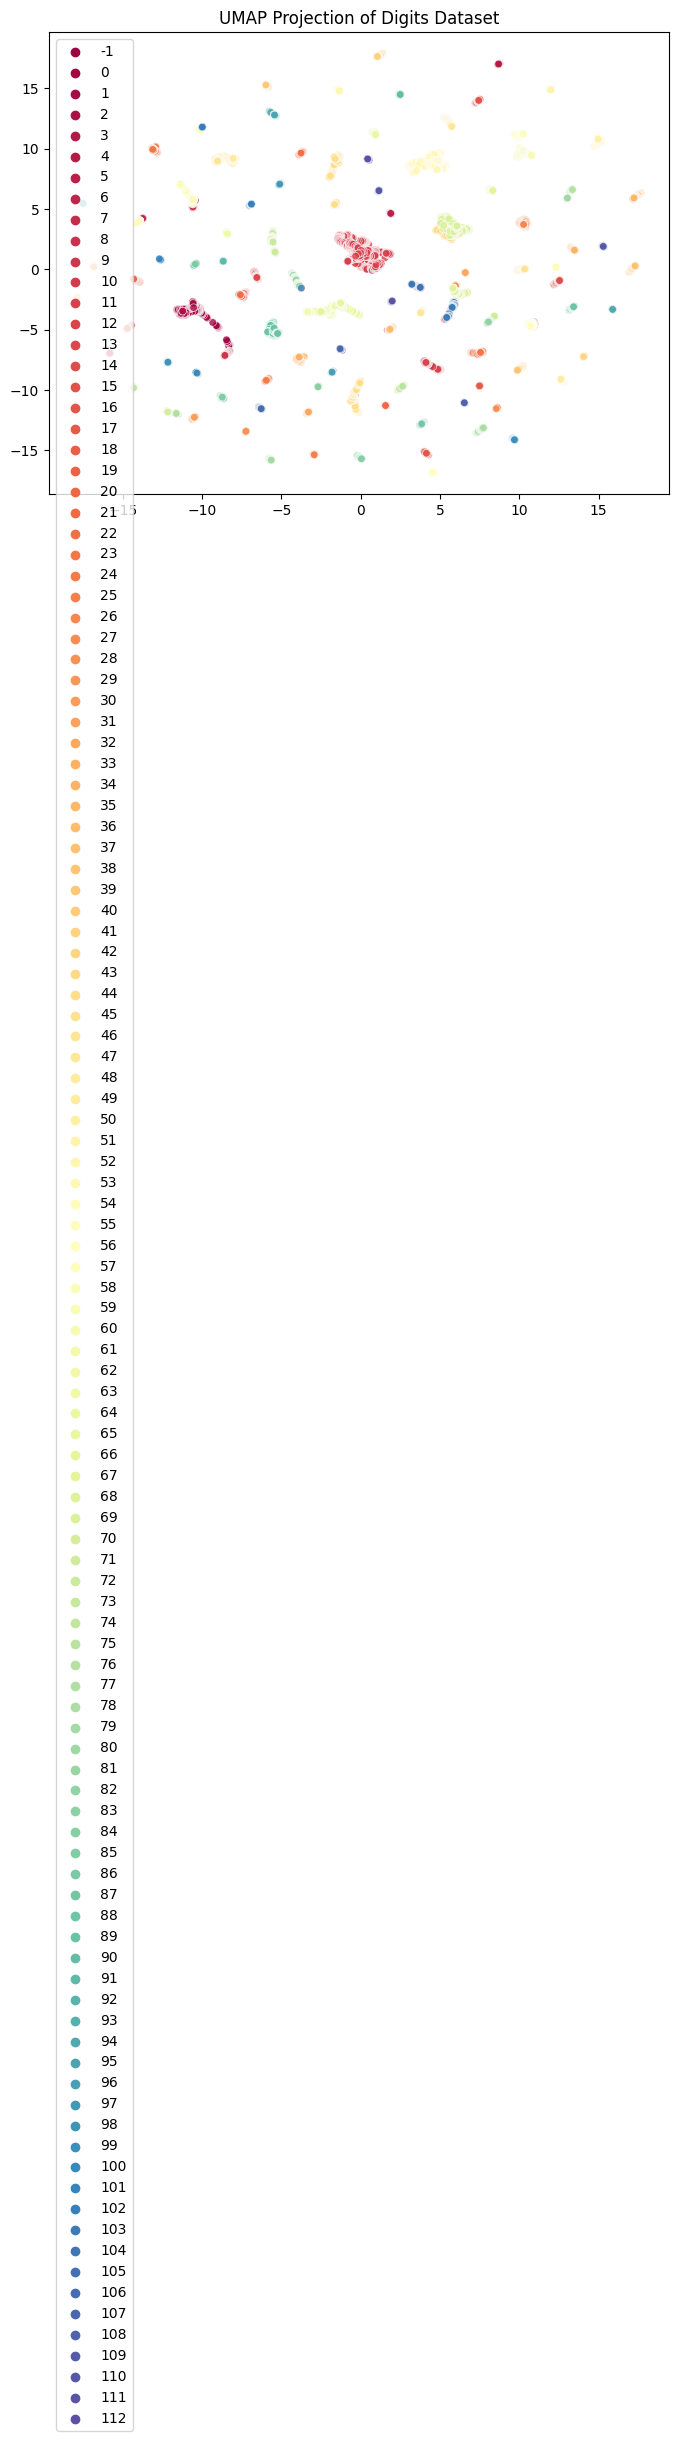

In [24]:
%matplotlib inline

# 4. Vẽ scatter plot
plt.figure(figsize=(8,6))
sns.scatterplot(
    x=X_umap[:,0], y=X_umap[:,1],
    hue=y, palette="Spectral",
    legend="full", s=30, alpha=0.8
)
plt.title("UMAP Projection of Digits Dataset")
plt.savefig("umap_plot.png", dpi=300, bbox_inches="tight")
print("Saved to umap_plot.png")

In [34]:
%%writefile /kaggle/working/Keyframe-Extraction-for-video-summarization/src/extraction/Keyframe_extraction.py
import pickle
import cv2
import numpy as np

from Kmeans_improvment import kmeans_silhouette
from Redundancy import redundancy
import sys
import os
sys.path.append('/kaggle/working/Keyframe-Extraction-for-video-summarization/src/scripts')
from save_keyframe import save_frames

def scen_keyframe_extraction(scenes_path, features_path, video_path, save_path, folder_path):
    # Get lens segmentation data
    number_list = []
    with open(scenes_path, 'r') as file:
        lines = file.readlines()
        for line in lines:
            numbers = line.strip().split(' ')
            number_list.extend([int(number) for number in numbers])

    # Read inference data from local
    with open(features_path, 'rb') as file:
        features = pickle.load(file)

    features = np.asarray(features)
    # print(len(features))

    # Clustering at each shot to obtain keyframe sequence numbers
    keyframe_index = []
    for i in range(0, len(number_list) - 1, 2):
        start = number_list[i]
        end = number_list[i + 1]
        print(start, end)
        sub_features = features[start:end]
        best_labels, best_centers, k, index = kmeans_silhouette(sub_features)
        final_index = [x + start for x in index]
        final_index.sort()
        print("clustering：" + str(keyframe_index))
        print(start, end)
        final_index = redundancy(video_path, final_index, 0.94)
        print("final_index：", final_index)
        keyframe_index += final_index
    keyframe_index.sort()
    print("final_index：" + str(keyframe_index))

    # save keyframe
    save_frames(keyframe_index, video_path, save_path, folder_path)

# ====== CHỈNH ĐƯỜNG DẪN ======
video_path = "/kaggle/input/keyframes-sample/L21_V001 (online-video-cutter.com).mp4"
scenes_path = "/kaggle/input/embeddings-scence/video_scenes.txt"
features_path = "/kaggle/input/embeddings-scence/video_features.pkl"

# Nơi lưu keyframes
save_path = "/kaggle/working"
folder_path = "video_keyframes"

os.makedirs(save_path, exist_ok=True)

scen_keyframe_extraction(
    scenes_path=scenes_path,
    features_path=features_path,
    video_path=video_path,
    save_path=save_path,
    folder_path=folder_path
)

print(f"✅ Keyframes đã lưu trong {os.path.join(save_path, folder_path)}")

Overwriting /kaggle/working/Keyframe-Extraction-for-video-summarization/src/extraction/Keyframe_extraction.py


In [32]:
%%writefile /kaggle/working/Keyframe-Extraction-for-video-summarization/src/extraction/init_center.py
import numpy as np
from tqdm import tqdm

def kmeans_init(data):
    print("🔹 In the process of initialising the center")
    n = len(data)
    sqrt_n = int(np.sqrt(n))           # số tâm cần chọn
    centers = []
    label = []

    # pick init_center
    while len(centers) < sqrt_n:
        sse_min = float('inf')
        join_center = data[0]

        # tqdm để quan sát tiến trình duyệt qua n điểm
        for i in tqdm(range(n), desc=f"Selecting center {len(centers)+1}/{sqrt_n}"):
            center = centers.copy()
            
            if len(centers) == 0 or not np.any(np.all(data[i] == centers, axis=1)):
                center.append(data[i])
                center = np.array(center)
                sse = 0.0

                # Cluster operation
                cluster_labels = np.zeros(len(data)).astype(int)
                for k in range(len(data)):
                    distances = [np.sqrt(np.sum((data[k] - cen) ** 2)) for cen in center]
                    nearest_cluster = np.argmin(distances)
                    cluster_labels[k] = nearest_cluster

                # Based on the results of the cluster operation, calculate sse
                for j in range(len(center)):
                    cluster_points = [data[l] for l in range(len(cluster_labels)) if cluster_labels[l] == j]
                    singe_sse = sum(np.linalg.norm(point - center[j]) for point in cluster_points)
                    sse += singe_sse

                if sse < sse_min:
                    sse_min = sse
                    join_center = data[i]
                    label = cluster_labels.copy()

        centers.append(join_center)

    return np.array(label), np.array(centers)

Overwriting /kaggle/working/Keyframe-Extraction-for-video-summarization/src/extraction/init_center.py


In [35]:
!python /kaggle/working/Keyframe-Extraction-for-video-summarization/src/extraction/Keyframe_extraction.py

0 52
🔹 In the process of initialising the center
Selecting center 7/7: 100%|████████████████████| 52/52 [00:00<00:00, 324.78it/s]
clustering：[]
0 52
18 0.97630537 10
26 0.97585595 10
[4, 10, 46]
final_index： [4, 10, 46]
54 342
🔹 In the process of initialising the center
Selecting center 16/16: 100%|█████████████████| 288/288 [00:10<00:00, 26.98it/s]
clustering：[4, 10, 46]
54 342
[81, 143]
final_index： [81, 143]
343 410
🔹 In the process of initialising the center
Selecting center 8/8: 100%|████████████████████| 67/67 [00:00<00:00, 196.16it/s]
clustering：[4, 10, 46, 81, 143]
343 410
[345, 358, 363, 370, 383, 396]
final_index： [345, 358, 363, 370, 383, 396]
411 457
🔹 In the process of initialising the center
Selecting center 6/6: 100%|████████████████████| 46/46 [00:00<00:00, 415.31it/s]
clustering：[4, 10, 46, 81, 143, 345, 358, 363, 370, 383, 396]
411 457
456 0.9922454 435
[413, 435]
final_index： [413, 435]
458 509
🔹 In the process of initialising the center
Selecting center 7/7: 100%|██